In [43]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup

In [44]:
# Hyperperemeter

LR = 6e-5
BATCH_SIZE = 16
MAX_LENGTH = 512
EPOCH = 30
NUM_CLASSES = 24
DROPOUT = 0.1
L2_REG = 1e-5
weight_decay = 0.01

In [45]:
label_mapping = {'INFORMATION-TECHNOLOGY': 0,\
                 'ENGINEERING':1, \
                 'BUSINESS-DEVELOPMENT':2, \
                 'SALES':3,\
                 'HR':4, \
                 'FITNESS': 5 , \
                 'ARTS':6,\
                 'ADVOCATE':7,\
                 'CONSTRUCTION':8,\
                 'AVIATION':9,\
                 'FINANCE':10,\
                 'CHEF':11,\
                 'ACCOUNTANT':12,\
                 'BANKING':13,\
                 'HEALTHCARE':14,\
                 'CONSULTANT':15,\
                 'PUBLIC-RELATIONS':16,\
                 'DESIGNER':17, \
                 'TEACHER':18, \
                 'APPAREL':19, \
                 'DIGITAL-MEDIA':20,\
                 'AGRICULTURE':21, \
                 'AUTOMOBILE':22,\
                 'BPO':23
                 }

In [46]:
def labeling(label):
    return label_mapping[label]

train_data = pd.read_csv("/kaggle/input/resumes/train_aug.csv")
val_data = pd.read_csv("/kaggle/input/resumes/val.csv")



train_data.dropna(inplace= True)
val_data.dropna(inplace= True)

train_data["Category"] = train_data["Category"].apply(labeling)
val_data["Category"] = val_data["Category"].apply(labeling)

In [47]:
val_data.head()

,Unnamed: 0,ID,Category,Cleaned_Resume
0,0,12212468,8,assistant project manager design build constru...
1,1,32385553,2,business development manager summary hard work...
2,2,43375498,13,customer service rep lead quality assurance co...
3,3,28035460,0,information technology specialist experience i...
4,4,18227306,15,consultant experience consultant january provi...


In [48]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please u

In [49]:
def generate_dataloader(df, tokenizer, max_length , batch_size):
    ids = np.zeros((len(df), max_length))
    masks = np.zeros((len(df), max_length))
    Y_labels = df['Category'].values

    for i, text in tqdm(enumerate(df['Cleaned_Resume'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=max_length,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='pt'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask

    X_ids =  torch.tensor(ids, dtype=torch.long)
    X_masks = torch.tensor(masks, dtype=torch.long)
    Y_labels = torch.tensor(Y_labels, dtype=torch.long)
    dataset = TensorDataset(X_ids, X_masks, Y_labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

In [50]:
train_loader = generate_dataloader(train_data, tokenizer,max_length =MAX_LENGTH,batch_size = BATCH_SIZE)
test_loader = generate_dataloader(val_data, tokenizer,max_length =MAX_LENGTH,batch_size = BATCH_SIZE)

2207it [01:03, 34.52it/s]
248it [00:07, 34.97it/s]


In [51]:
# Define the model architecture with dropout and L2 regularization
class TextModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3, l2_reg=1e-5):
        super(TextModel, self).__init__()
        self.bert = model
        self.intermediate_layer = nn.Linear(768, 512)
        self.dropout = nn.Dropout(dropout_prob)  # Dropout layer added
        self.output_layer = nn.Linear(512, num_classes)

        # L2 regularization added to linear layers
        self.intermediate_layer.weight.data = nn.init.kaiming_normal_(self.intermediate_layer.weight.data)
        self.intermediate_layer.bias.data.fill_(0)
        self.output_layer.weight.data = nn.init.kaiming_normal_(self.output_layer.weight.data)
        self.output_layer.bias.data.fill_(0)

        self.l2_reg = l2_reg

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
        intermediate = self.intermediate_layer(outputs)
        intermediate = self.dropout(intermediate)  # Apply dropout
        logits = self.output_layer(intermediate)
        return logits

In [52]:
model = TextModel(NUM_CLASSES, dropout_prob=DROPOUT, l2_reg=L2_REG)

In [53]:
# Move the model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

TextModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [55]:
# Calculate class weights
Y_labels = train_data['Category'].values
# Step 2: Calculate class counts using np.bincount()
class_counts = np.bincount(Y_labels)

# Step 3: Calculate class weights as the inverse of the class frequency
class_weights = torch.tensor([1.0 / count if count > 0 else 0.0 for count in class_counts], dtype=torch.float)

# Step 4: Move class weights to the GPU if required
class_weights = class_weights.to(device)
class_weights

tensor([0.0104, 0.0106, 0.0105, 0.0108, 0.0111, 0.0106, 0.0111, 0.0106, 0.0111,
        0.0108, 0.0106, 0.0106, 0.0106, 0.0109, 0.0109, 0.0109, 0.0111, 0.0111,
        0.0111, 0.0111, 0.0111, 0.0111, 0.0111, 0.0111], device='cuda:0')

In [56]:
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": weight_decay,
    },
    {
        "params": [
            p
            for n, p in model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

In [57]:
# Define optimizer and loss function
# Define the number of training steps
num_train_steps = (len(train_loader) // BATCH_SIZE) * EPOCH
optimizer = optim.AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
criterion = nn.CrossEntropyLoss(weight=class_weights)

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)

### **Training Module**

In [59]:
# Define early stopping and model checkpointing
from sklearn.metrics import accuracy_score
train_acc =[]
valid_acc = []
train_loss =[]


best_val_accuracy = 0.0
early_stopping_counter = 0

# Training loop with early stopping and model checkpointing
for epoch in range(EPOCH):
    model.train()
    total_loss = 0.0
    predictions = []
    targets = []
    print(f"---------Epoch:{epoch}----------")
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids, attn_masks, labels = batch
        input_ids, attn_masks, labels = input_ids.to(device), attn_masks.to(device), labels.to(device)

        outputs = model(input_ids, attn_masks)
        loss = criterion(outputs, labels)

        # Apply L2 regularization to linear layers
        l2_loss = torch.tensor(0.).to(device)
        for param in model.parameters():
            if param.dim() > 1:
                l2_loss += torch.norm(param, p=2)  # L2 norm
        loss += L2_REG * l2_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions.extend(torch.argmax(outputs, dim=1).tolist())
        targets.extend(labels.tolist())
    avg_loss = total_loss / len(train_loader)
    acc = accuracy_score(targets, predictions)

    # Validation step
    model.eval()
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for val_batch in tqdm(test_loader):
            val_input_ids, val_attn_masks, val_labels = val_batch
            val_input_ids, val_attn_masks, val_labels = val_input_ids.to(device), val_attn_masks.to(device), val_labels.to(device)

            val_outputs = model(val_input_ids, val_attn_masks)
            val_predictions.extend(torch.argmax(val_outputs, dim=1).tolist())
            val_targets.extend(val_labels.tolist())

    val_acc = accuracy_score(val_targets, val_predictions)

    print(f"Epoch {epoch+1}/{EPOCH} - Avg. Loss: {avg_loss:.4f} - Accuracy: {acc:.4f} - Val Accuracy: {val_acc:.4f}")

    # Check for early stopping
    if acc > best_val_accuracy:
        best_val_accuracy = acc
        early_stopping_counter = 0
        torch.save(model.state_dict(), f"/kaggle/working/best_model_epoch_{epoch+1}_{val_acc}.pt")
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= 8:
            print("Early stopping triggered.")
            break
    train_acc.append(acc)
    train_loss.append(avg_loss)
    valid_acc.append(val_acc)

---------Epoch:0----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 1/30 - Avg. Loss: 2.4436 - Accuracy: 0.3140 - Val Accuracy: 0.7177
---------Epoch:1----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 2/30 - Avg. Loss: 0.9055 - Accuracy: 0.7825 - Val Accuracy: 0.8387
---------Epoch:2----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 3/30 - Avg. Loss: 0.5903 - Accuracy: 0.8618 - Val Accuracy: 0.8427
---------Epoch:3----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 4/30 - Avg. Loss: 0.4822 - Accuracy: 0.8826 - Val Accuracy: 0.8508
---------Epoch:4----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 5/30 - Avg. Loss: 0.3342 - Accuracy: 0.9203 - Val Accuracy: 0.8508
---------Epoch:5----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 6/30 - Avg. Loss: 0.2198 - Accuracy: 0.9497 - Val Accuracy: 0.8266
---------Epoch:6----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 7/30 - Avg. Loss: 0.1696 - Accuracy: 0.9669 - Val Accuracy: 0.8548
---------Epoch:7----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 8/30 - Avg. Loss: 0.1583 - Accuracy: 0.9705 - Val Accuracy: 0.7823
---------Epoch:8----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 9/30 - Avg. Loss: 0.1590 - Accuracy: 0.9660 - Val Accuracy: 0.8306
---------Epoch:9----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 10/30 - Avg. Loss: 0.1127 - Accuracy: 0.9769 - Val Accuracy: 0.8226
---------Epoch:10----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 11/30 - Avg. Loss: 0.1123 - Accuracy: 0.9769 - Val Accuracy: 0.8266
---------Epoch:11----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 12/30 - Avg. Loss: 0.0989 - Accuracy: 0.9823 - Val Accuracy: 0.8387
---------Epoch:12----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 13/30 - Avg. Loss: 0.0811 - Accuracy: 0.9873 - Val Accuracy: 0.8629
---------Epoch:13----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 14/30 - Avg. Loss: 0.1090 - Accuracy: 0.9810 - Val Accuracy: 0.8185
---------Epoch:14----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 15/30 - Avg. Loss: 0.1359 - Accuracy: 0.9687 - Val Accuracy: 0.7863
---------Epoch:15----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 16/30 - Avg. Loss: 0.1022 - Accuracy: 0.9814 - Val Accuracy: 0.8105
---------Epoch:16----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 17/30 - Avg. Loss: 0.0904 - Accuracy: 0.9810 - Val Accuracy: 0.8065
---------Epoch:17----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 18/30 - Avg. Loss: 0.1221 - Accuracy: 0.9733 - Val Accuracy: 0.8105
---------Epoch:18----------


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 19/30 - Avg. Loss: 0.0878 - Accuracy: 0.9878 - Val Accuracy: 0.8387
---------Epoch:19----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 20/30 - Avg. Loss: 0.0926 - Accuracy: 0.9837 - Val Accuracy: 0.8387
---------Epoch:20----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 21/30 - Avg. Loss: 0.0894 - Accuracy: 0.9878 - Val Accuracy: 0.8548
---------Epoch:21----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 22/30 - Avg. Loss: 0.0480 - Accuracy: 0.9955 - Val Accuracy: 0.8427
---------Epoch:22----------


100%|██████████| 16/16 [00:03<00:00,  4.24it/s]


Epoch 23/30 - Avg. Loss: 0.0367 - Accuracy: 0.9968 - Val Accuracy: 0.8387
---------Epoch:23----------


100%|██████████| 16/16 [00:03<00:00,  4.23it/s]


Epoch 24/30 - Avg. Loss: 0.0711 - Accuracy: 0.9887 - Val Accuracy: 0.8145
---------Epoch:24----------


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 25/30 - Avg. Loss: 0.1021 - Accuracy: 0.9823 - Val Accuracy: 0.8427
---------Epoch:25----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 26/30 - Avg. Loss: 0.0560 - Accuracy: 0.9937 - Val Accuracy: 0.8548
---------Epoch:26----------


100%|██████████| 16/16 [00:03<00:00,  4.25it/s]


Epoch 27/30 - Avg. Loss: 0.0810 - Accuracy: 0.9896 - Val Accuracy: 0.8427
---------Epoch:27----------


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 28/30 - Avg. Loss: 0.1556 - Accuracy: 0.9692 - Val Accuracy: 0.8266
---------Epoch:28----------


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]


Epoch 29/30 - Avg. Loss: 0.0773 - Accuracy: 0.9850 - Val Accuracy: 0.8185
---------Epoch:29----------


100%|██████████| 16/16 [00:03<00:00,  4.26it/s]

Epoch 30/30 - Avg. Loss: 0.0590 - Accuracy: 0.9946 - Val Accuracy: 0.8468


In [60]:
len(train_loss)

30

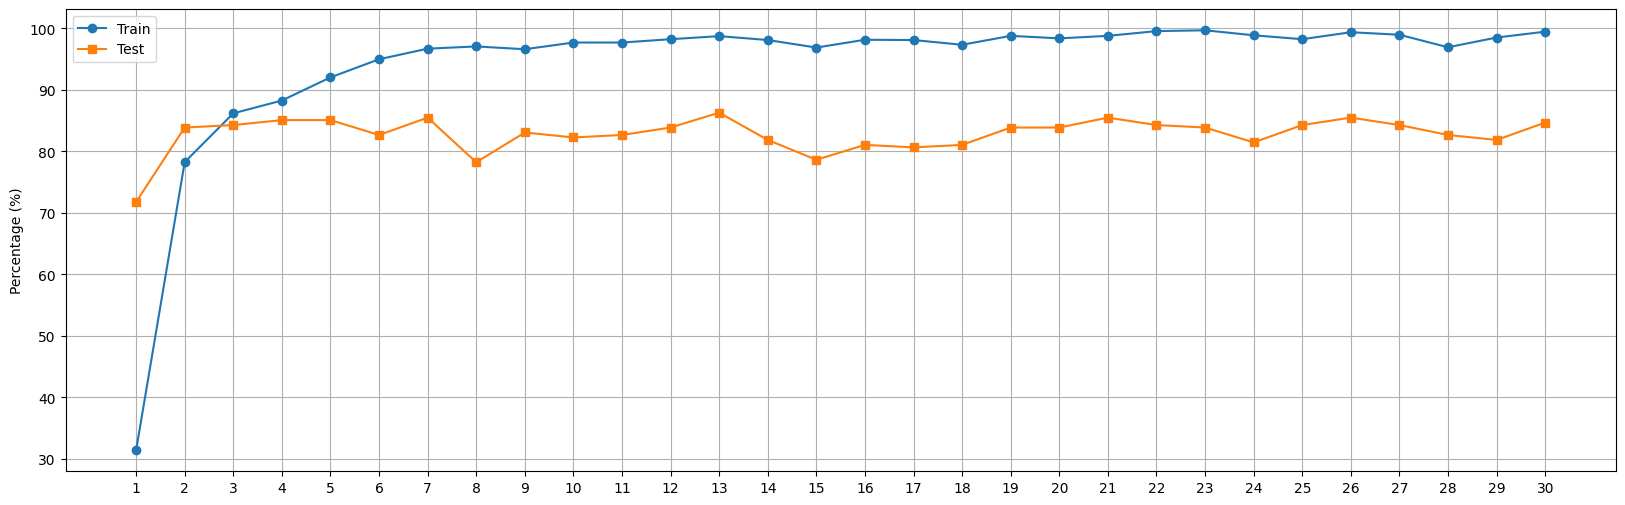

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: replace these with your actual data
list1 = train_acc  
list2 = valid_acc  

# Calculate percentages for each value in the lists
percentages1 = [100 * value  for value in list1]
percentages2 = [100 * value  for value in list2]

# Create a list of index positions for the x-axis
x = np.arange(len(list1))

# Set the figure size
plt.figure(figsize=(20, 6))  

# Create the line graph
plt.plot(x, percentages1, marker='o', label='Train')
plt.plot(x, percentages2, marker='s', label='Test')

# Set x-axis ticks and labels
plt.xticks(x, range(1, len(list1) + 1))

# Set y-axis label as a percentage
plt.ylabel('Percentage (%)')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

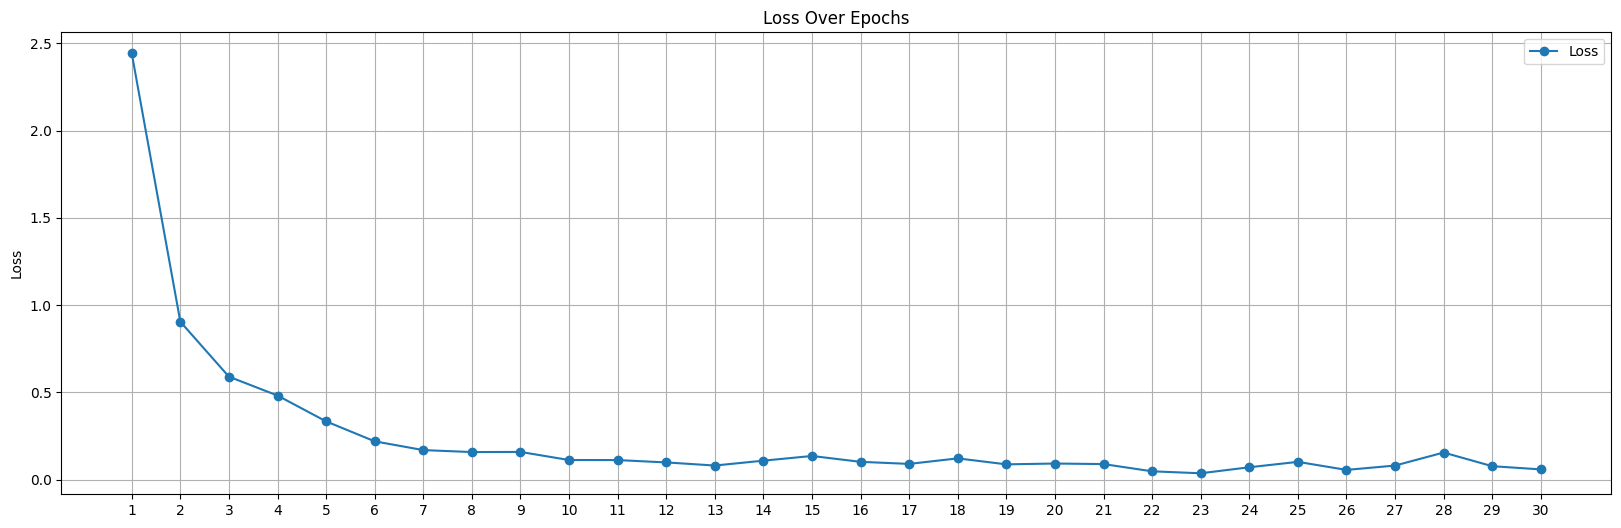

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Example loss values: replace this with your actual data
loss_list = train_loss  # Replace with your data

# Create a list of index positions for the x-axis
x = np.arange(len(loss_list))

# Set the figure size
plt.figure(figsize=(20, 6))  # Adjust the width and height as needed

# Create the line graph
plt.plot(x, loss_list, marker='o', label='Loss')

# Set x-axis ticks and labels
plt.xticks(x, range(1, len(loss_list) + 1))

# Set y-axis label
plt.ylabel('Loss')

# Add a title
plt.title('Loss Over Epochs')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

In [63]:
model_root = BertModel.from_pretrained('bert-base-cased')

# Define the model architecture with dropout and L2 regularization
class TextModel(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.3, l2_reg=1e-5):
        super(TextModel, self).__init__()
        self.bert = model_root
        self.intermediate_layer = nn.Linear(768, 512)
        self.dropout = nn.Dropout(dropout_prob)
        self.output_layer = nn.Linear(512, num_classes)
        
        # L2 regularization added to linear layers
        self.intermediate_layer.weight.data = nn.init.kaiming_normal_(self.intermediate_layer.weight.data)
        self.intermediate_layer.bias.data.fill_(0)
        self.output_layer.weight.data = nn.init.kaiming_normal_(self.output_layer.weight.data)
        self.output_layer.bias.data.fill_(0)
        
        self.l2_reg = l2_reg
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)[1]
        intermediate = self.intermediate_layer(outputs)
        intermediate = self.dropout(intermediate)
        logits = self.output_layer(intermediate)
        return logits

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [66]:
test_data = pd.read_csv("/kaggle/input/resumes-test/test.csv")
test_data.dropna(inplace= True)
test_data["Category"] = test_data["Category"].apply(labeling)
ntest_loader = generate_dataloader(test_data, tokenizer,max_length =MAX_LENGTH,batch_size = BATCH_SIZE)

249it [00:07, 34.82it/s]


### **Accuracy Matrics**

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
ckpt = "/kaggle/working/best_model_epoch_13_0.8629032258064516.pt"
# Load the trained model checkpoint
model = TextModel(num_classes=24)
model.to(device)
model.load_state_dict(torch.load(ckpt))
model.eval()

test_predictions = []
test_targets = []

with torch.no_grad():
    for test_batch in tqdm(ntest_loader):
        test_input_ids, test_attn_masks, test_labels = test_batch
        test_input_ids, test_attn_masks, test_labels = test_input_ids.to(device), test_attn_masks.to(device), test_labels.to(device)
        
        test_outputs = model(test_input_ids, test_attn_masks)
        test_predictions.extend(torch.argmax(test_outputs, dim=1).tolist())
        test_targets.extend(test_labels.tolist())

test_acc = accuracy_score(test_targets, test_predictions)
test_precision = precision_score(test_targets, test_predictions, average='weighted')
test_recall = recall_score(test_targets, test_predictions, average='weighted')
test_f1 = f1_score(test_targets, test_predictions, average='weighted')

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

/tmp/ipykernel_36/380975785.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt))
100%|██████████| 16/16 [00:03<00:00,  4.25it/s]

Test Accuracy: 0.8434
Test Precision: 0.8375
Test Recall: 0.8434
Test F1-score: 0.8363
